In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor

In [2]:
# building_id = 32
# subset_df = pd.read_csv('/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/subset20.csv')
# processed_df = pd.read_csv(f'/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp/{building_id}.csv')


md_path = '/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/md_one_hot_encoded_subset20.csv'
PATH = '/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp/'
json_file = '../data/subset20_20_data.json'

In [3]:
md = pd.read_csv(md_path)
with open(json_file, 'r') as file:
    json_data = json.load(file)

In [4]:
md.head

<bound method NDFrame.head of       bldg_id  in.state  in.vintage   in.sqft  \
0      105885        10           3  750000.0   
1      305819        40           2  150000.0   
2      305934        40           4  350000.0   
3      317044        40           3  350000.0   
4          32         1           6   37500.0   
...       ...       ...         ...       ...   
6396   331879        42           1   37500.0   
6397   331938        42           3   37500.0   
6398   332036        42           3    3000.0   
6399   332037        42           1   17500.0   
6400   332051        42           2   37500.0   

      in.building_america_climate_zone_Cold  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
6396                                      0   
6397 

In [5]:
md.columns

Index(['bldg_id', 'in.state', 'in.vintage', 'in.sqft',
       'in.building_america_climate_zone_Cold',
       'in.building_america_climate_zone_Hot-Dry',
       'in.building_america_climate_zone_Hot-Humid',
       'in.building_america_climate_zone_Marine',
       'in.building_america_climate_zone_Mixed-Dry',
       'in.building_america_climate_zone_Mixed-Humid',
       'in.building_america_climate_zone_Subarctic',
       'in.building_america_climate_zone_Very Cold', 'in.iso_rto_region_CAISO',
       'in.iso_rto_region_ERCOT', 'in.iso_rto_region_MISO',
       'in.iso_rto_region_NEISO', 'in.iso_rto_region_NYISO',
       'in.iso_rto_region_PJM', 'in.iso_rto_region_SPP',
       'in.iso_rto_region_none', 'in.heating_fuel_DistrictHeating',
       'in.heating_fuel_Electricity', 'in.heating_fuel_FuelOil',
       'in.heating_fuel_NaturalGas', 'in.heating_fuel_Propane',
       'in.interior_lighting_generation_gen1_t12_incandescent',
       'in.interior_lighting_generation_gen2_t8_halogen',
     

In [6]:
train_bldg_ids = json_data.get("train_bldg_ids", [])
test_bldg_ids = json_data.get("test_bldg_ids", [])

In [7]:
train_bldg_ids = [filename.split('.')[0] for filename in train_bldg_ids]
test_bldg_ids = [filename.split('.')[0] for filename in test_bldg_ids]

md['bldg_id'] = md['bldg_id'].astype(str).str.strip()

In [8]:
education_buildings = md[md['in.comstock_building_type_group_Education'] == 1]
education_bldg_ids = education_buildings['bldg_id'].unique()

In [9]:
print(f"Education Building IDs: {education_bldg_ids[:10]}")

Education Building IDs: ['1025' '3050' '3587' '5623' '5778' '6141' '7137' '10351' '12020' '13244']


In [10]:
valid_train_bldgs = set(train_bldg_ids).intersection(education_bldg_ids)
valid_test_bldgs = set(test_bldg_ids).intersection(education_bldg_ids)

print(f"Valid train buildings: {valid_train_bldgs}")
print(f"Valid test buildings: {valid_test_bldgs}")

Valid train buildings: {'300121', '33545', '140525', '172879', '175636', '308369', '324210', '329909', '317195', '109381', '160500', '15554', '239266', '197094', '302537', '68162', '216573', '76284', '122765', '141937', '147211', '184684', '129318', '99553', '320417', '200843', '130137', '256321', '51767', '129232', '286199', '138433', '304075', '260641', '202677', '241943', '222427', '132028', '130424', '49168', '317886', '85280', '222812', '131132', '82929', '157959', '104791', '5778', '91960', '282426', '286832', '178999', '297199', '32211', '97705', '257381', '28870', '232165', '200025', '115516', '196938', '116162', '100509', '233818', '242077', '313003', '268181', '41538', '224597', '290293', '330851', '105735', '315062', '46736', '142950', '18768', '157920', '87513', '185619', '146220', '202498', '39806', '166330', '112004', '324067', '198468', '306876', '132936', '143155', '229930', '220209', '5623', '191781', '40167', '325674', '38370', '173742', '235879', '309670', '142128', 

In [11]:
print(f"Number of valid training buildings: {len(valid_train_bldgs)}")
print(f"Number of valid testing buildings: {len(valid_test_bldgs)}")


Number of valid training buildings: 120
Number of valid testing buildings: 33


In [12]:
def load_data_for_building(filename, directory):
    try:
        file_path = f"{directory}/{filename}.csv"
        print(f"Loading file: {file_path}")
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error loading file {filename}: {e}")
        return None


In [13]:
def prepare_data_for_building(df_load, md):
    df_load['bldg_id'] = df_load['bldg_id'].astype(str)
    md['bldg_id'] = md['bldg_id'].astype(str)

    for i in range(1, 97):
        df_load[f"shift_{i}"] = df_load["out.electricity.total.energy_consumption"].shift(i)

    if 'timestamp' in df_load.columns:
        df_load['timestamp'] = pd.to_datetime(df_load['timestamp'])
        
        datetime_columns = {
            'hour': df_load['timestamp'].dt.hour,
            'day_of_week': df_load['timestamp'].dt.dayofweek,
            'day_of_year': df_load['timestamp'].dt.dayofyear,
            'month': df_load['timestamp'].dt.month,
            'year': df_load['timestamp'].dt.year
        }
        
        df_load = pd.concat([df_load, pd.DataFrame(datetime_columns)], axis=1)
        df_load = df_load.drop(columns=['timestamp'])  # drop timestamp after extraction

    merged_df = df_load.merge(md, on='bldg_id', how='left')
    merged_df = merged_df.drop(['bldg_id'], axis=1)  # Drop building ID for model input

    # drop missing values
    merged_df = merged_df.dropna()
    
    return merged_df

In [14]:
def smape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    denominator = np.abs(actual) + np.abs(predicted)
    diff = np.abs(actual - predicted) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [21]:
def plot_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_pred.values, label='Predicted', color='red', zorder=2)
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue', zorder=1)
    plt.xlabel('Time')
    plt.ylabel('Electricity Consumption')
    plt.title('Random Forest: Actual vs Predicted Electricity Consumption')
    plt.legend()
    plt.show()

In [22]:
def train_random_forest_model(directory, valid_train_bldgs, valid_test_bldgs, target_column='out.electricity.total.energy_consumption'):
    smape_train_list = []
    smape_test_list = []

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # test specific building (329909)
    building_to_test = '329909'
    print(f"Training on building: {building_to_test}")

    train_df = load_data_for_building(building_to_test, directory)
    if train_df is not None and target_column in train_df:
        print(f"Data loaded for {building_to_test}")
        
        train_df_prepared = prepare_data_for_building(train_df, md)
        
        if train_df_prepared is not None and len(train_df_prepared) > 0:
            print(f"Data prepared for {building_to_test}")

            X_train = train_df_prepared.drop(columns=[target_column])
            y_train = train_df_prepared[target_column]

            # train Random Forest model
            model.fit(X_train, y_train)
            print(f"Model trained on {building_to_test}")

            # predictions for training data
            y_train_pred = model.predict(X_train)

            # SMAPE for training data
            smape_train = smape(y_train, y_train_pred)
            smape_train_list.append(smape_train)
            print(f"SMAPE for {building_to_test}: {smape_train}")

            y_train_pred_series = pd.Series(y_train_pred, index=y_train.index)
            
            # plot actual vs predicted
            plot_results(y_train, y_train_pred_series)


        else:
            print(f"Prepared data is empty for {building_to_test}")
    else:
        print(f"Skipping {building_to_test} due to missing data")

    return smape_train_list, smape_test_list

Training on building: 329909
Loading file: /Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp//329909.csv
Data loaded for 329909
Data prepared for 329909
Model trained on 329909
SMAPE for 329909: 1.4779328044820594


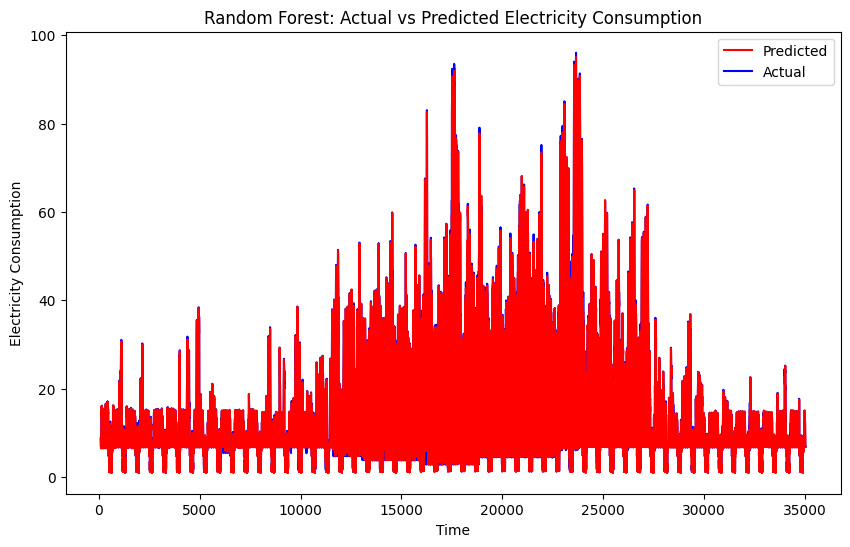

Training SMAPE scores: [1.4779328044820594]
Testing SMAPE scores: []


In [23]:
smape_train_list, smape_test_list = train_random_forest_model(PATH, valid_train_bldgs, valid_test_bldgs)

# Output the results
print(f"Training SMAPE scores: {smape_train_list}")
print(f"Testing SMAPE scores: {smape_test_list}")